# Computing the PCA of a Trees for BW2508 Dataset

In [ ]:
%load_ext autoreload
%autoreload 2

import pickle
import sys
from pathlib import Path

dinov3_repo_path = Path("/home/nati/source/dinov3")
sys.path.extend(["/home/nati/source/ml-common/src"])

import os

os.chdir(dinov3_repo_path)

In [2]:
dino_patch_size = 16
dino_image_size = 768
dataset_path = Path("/home/nati/source/datasets/bw2508")
model_name = "dinov3_vits16"
checkpoint_path = Path("/home/nati/source/dinov3/checkpoints/dinov3_vits16_pretrain.pth")
classifier_path = Path("/home/nati/source/dataOut/dinov3/dino_bw/fg_classifier_tree_c_0.1.pkl")
output_dir = Path("/home/nati/source/dataOut/dinov3/dino_bw/inference_results")
segmentation_class_name = "tree"

In [4]:
from bw_ml_common.datasets.data_accessor_factory import create_dataset_accessor
from dino_bw.dino_classifier_inference import regress_dino_embeddings, visualize_results
from dino_bw.dino_embeddings_utils import get_class_idx_from_name, load_dinov3_model
from dino_bw.bw_defs import MODEL_TO_NUM_LAYERS


In [5]:
model = load_dinov3_model(dinov3_location=dinov3_repo_path, model_name=model_name, checkpoint_path=checkpoint_path)
with open(classifier_path, 'rb') as file:
    classifier = pickle.load(file)
accessor = create_dataset_accessor(dataset_name=dataset_path.stem, data_root=str(dataset_path.parent),
                                   split_name="val")
accessor.update_lookup_tables_with_task()
samples = accessor.populate(stable=True)
class_idx = get_class_idx_from_name(accessor, segmentation_class_name)

n_layers = MODEL_TO_NUM_LAYERS[model_name]

INFO: using base=100 for rope new
INFO: using min_period=None for rope new
INFO: using max_period=None for rope new
INFO: using normalize_coords=separate for rope new
INFO: using shift_coords=None for rope new
INFO: using rescale_coords=2 for rope new
INFO: using jitter_coords=None for rope new
INFO: using dtype=fp32 for rope new
INFO: using mlp layer as FFN


Loading DINOv3 model: dinov3_vits16


Data Accessor - INFO - [dataset_accessor.py:344] - Accessor bw2508/val: Reading samples from /home/nati/source/datasets/bw2508/splits/val.txt
Data Accessor - INFO - [dataset_accessor.py:182] - Accessor bw2508/val: Using 100 samples.


Model loaded successfully


Data Accessor - INFO - [dataset_accessor.py:592] - Created LUT of size: 16777216, with target classes: 16


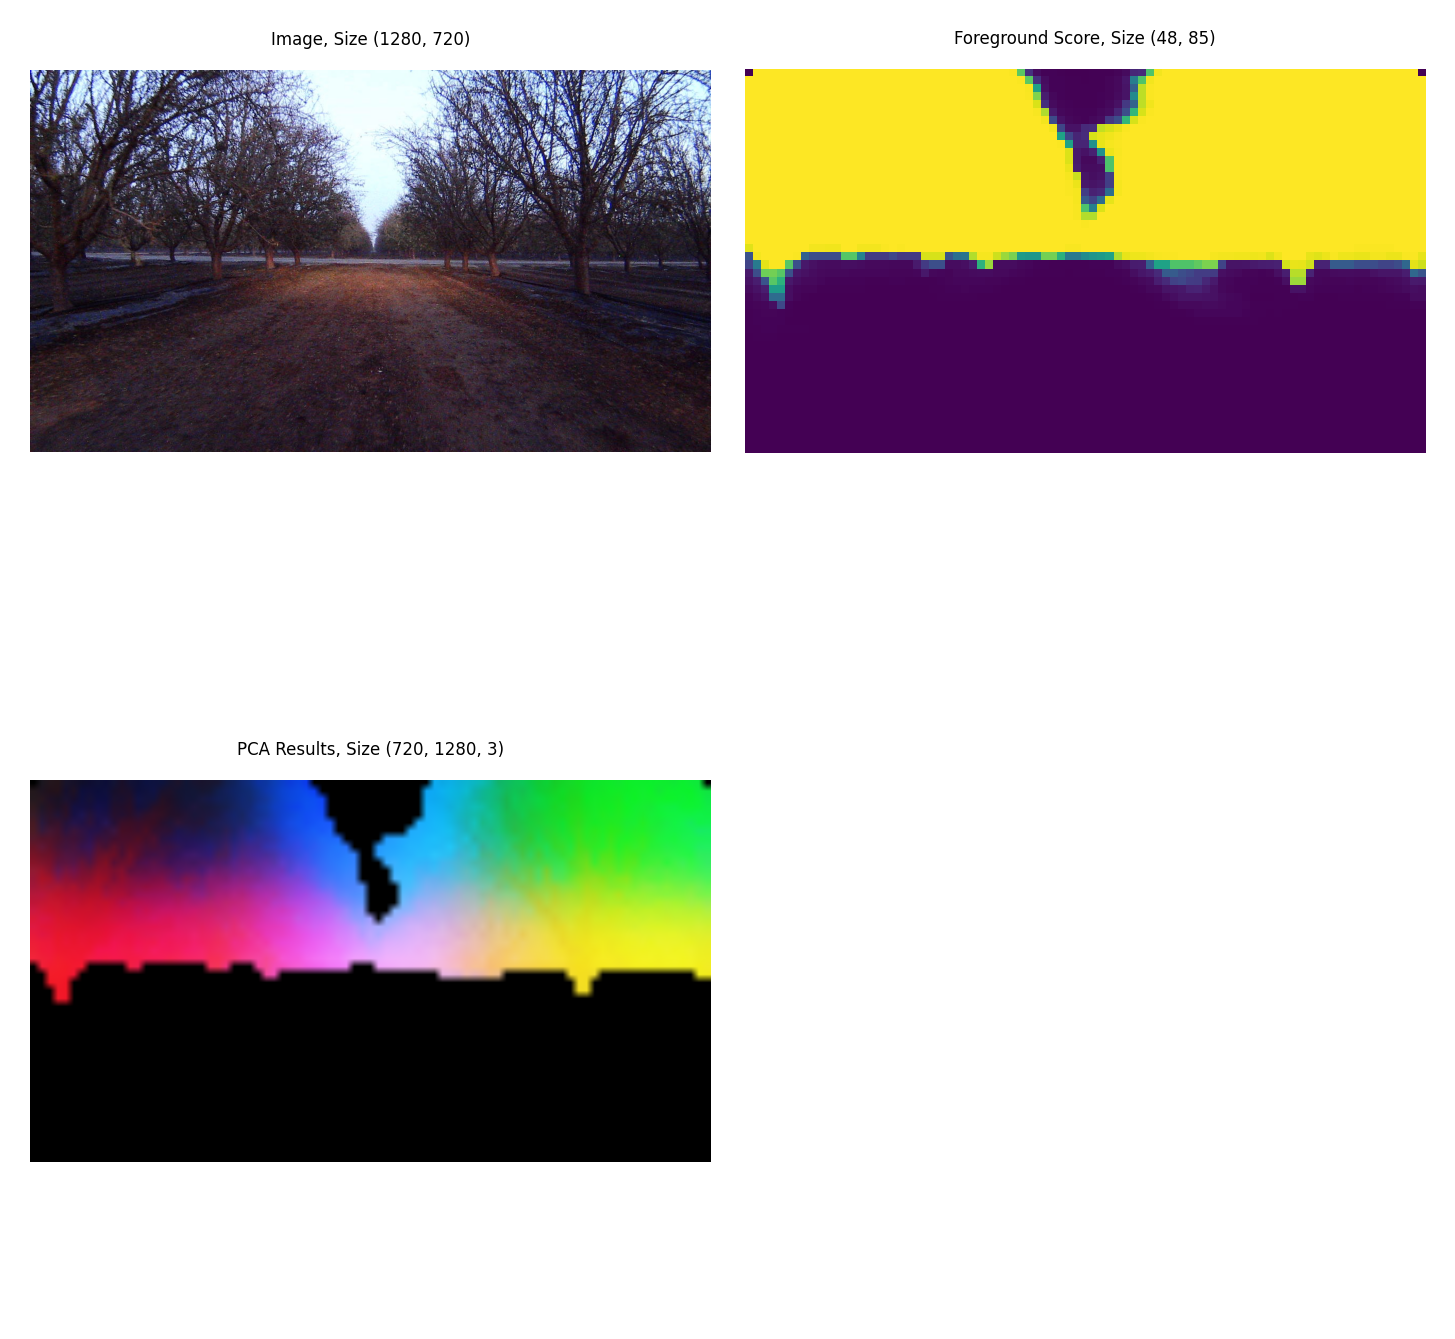

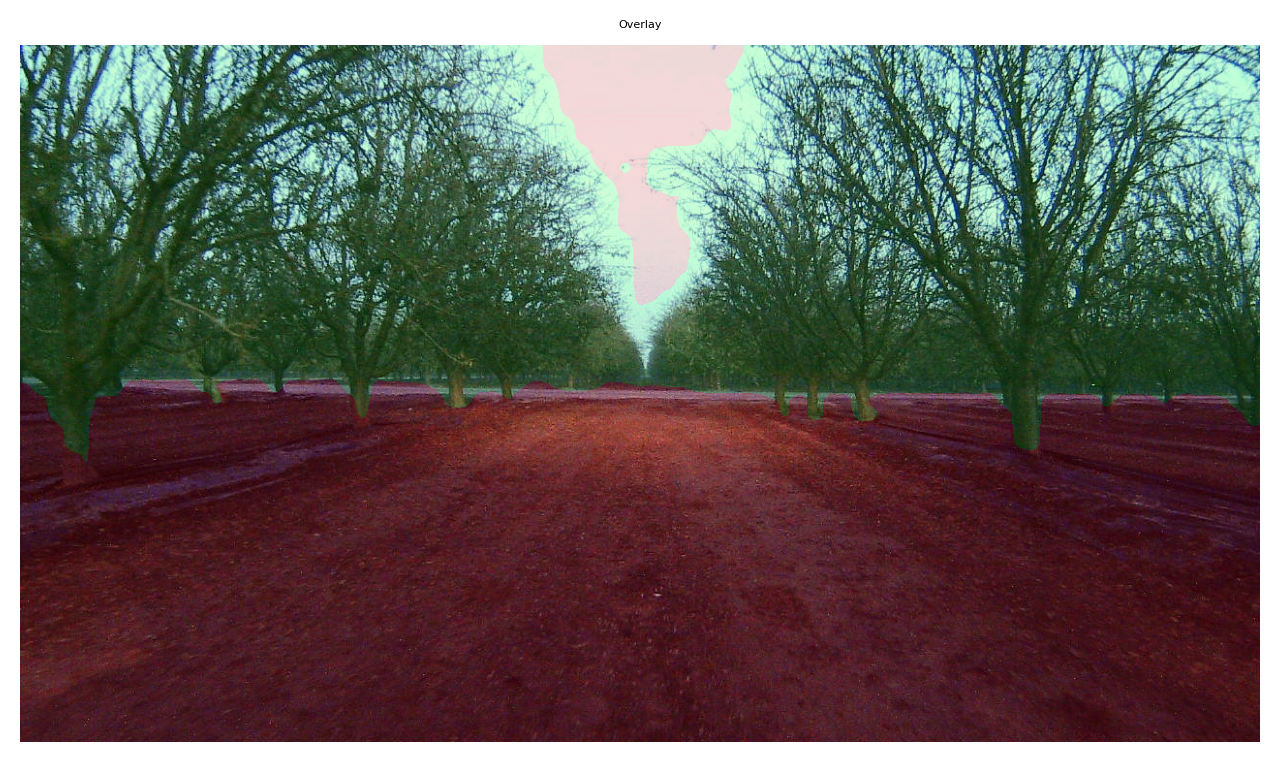

In [ ]:
for i, chosen_sample in enumerate(samples):
    image_path = chosen_sample["image_path"]
    image = accessor.read_image(image_path)
    image_name = Path(image_path).stem
    dino_regression_result = regress_dino_embeddings(model, classifier, image=image, n_layers=n_layers,
                                                     image_size=dino_image_size, patch_size=dino_patch_size)
    visualize_results(image=image, result=dino_regression_result, output_dir=output_dir, image_name=image_name)


#### Boiler Plate

In [ ]:
## Process and analyze images in batch

# Let's process a few images from the dataset
num_images_to_process = 5
for i in range(num_images_to_process):
    chosen_sample = samples[i]
    image_path = chosen_sample["image_path"]
    image = accessor.read_image(image_path)
    image_name = Path(image_path).stem

    print(f"Processing image {i + 1}/{num_images_to_process}: {image_name}")

    # Process the image
    fg_score_mf, projected_img_resized = process_image(
        model, classifier, image, n_layers, dino_image_size, dino_patch_size
    )

    # Visualize and save the results
    visualize_results(
        image, fg_score_mf, projected_img_resized, output_dir=output_dir, image_name=image_name
    )

print("Batch processing complete.")


### Loading an Image and Applying the Right Transform
Let's load an image and process it in order to make it a multiple of the patch size.

In [6]:
PATCH_SIZE = 16
IMAGE_SIZE = 768

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

image_uri = "https://dl.fbaipublicfiles.com/dinov3/notebooks/pca/test_image.jpg"


def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")


# image resize transform to dimensions divisible by patch size
def resize_transform(
        mask_image: Image,
        image_size: int = IMAGE_SIZE,
        patch_size: int = PATCH_SIZE,
) -> torch.Tensor:
    w, h = mask_image.size
    h_patches = int(image_size / patch_size)
    w_patches = int((w * image_size) / (h * patch_size))
    return TF.to_tensor(TF.resize(mask_image, (h_patches * patch_size, w_patches * patch_size)))


image = load_image_from_url(image_uri)
image_resized = resize_transform(image)
image_resized_norm = TF.normalize(image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)

### Model Forward
Given the input image, we compute local features:

In [11]:
MODEL_TO_NUM_LAYERS = {
    MODEL_DINOV3_VITS: 12,
    MODEL_DINOV3_VITSP: 12,
    MODEL_DINOV3_VITB: 12,
    MODEL_DINOV3_VITL: 24,
    MODEL_DINOV3_VITHP: 32,
    MODEL_DINOV3_VIT7B: 40,
}

n_layers = MODEL_TO_NUM_LAYERS[model_name]
with torch.inference_mode():
    with torch.autocast(device_type='cuda', dtype=torch.float32):
        feats = model.get_intermediate_layers(image_resized_norm.unsqueeze(0).cuda(), n=range(n_layers), reshape=True,
                                              norm=True)
        x = feats[-1].squeeze().detach().cpu()
        dim = x.shape[0]
        x = x.view(dim, -1).permute(1, 0)

### Computing Foreground Probability
Let's now pass all those features through our foreground classifier, extract probabilities, and reshape.

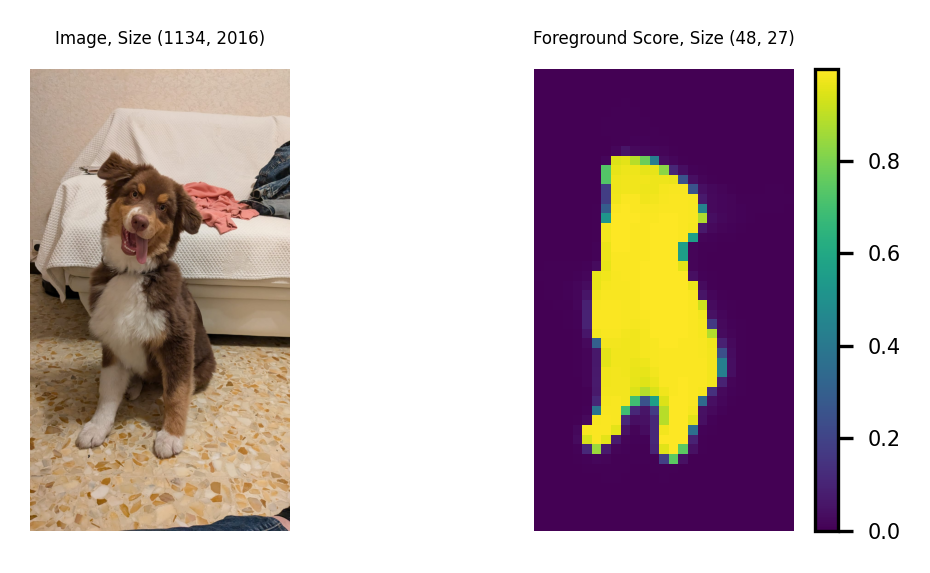

In [18]:
h_patches, w_patches = [int(d / PATCH_SIZE) for d in image_resized.shape[1:]]

fg_score = clf.predict_proba(x)[:, 1].reshape(h_patches, w_patches)
fg_score_mf = torch.from_numpy(signal.medfilt2d(fg_score, kernel_size=3))

plt.rcParams.update({
    "xtick.labelsize": 5,
    "ytick.labelsize": 5,
    "axes.labelsize": 5,
    "axes.titlesize": 4,
})

plt.figure(figsize=(4, 2), dpi=300)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title(f"Image, Size {image.size}")
plt.subplot(1, 2, 2)
plt.imshow(fg_score_mf)
plt.title(f"Foreground Score, Size {tuple(fg_score_mf.shape)}")
plt.colorbar()
plt.axis('off')
plt.show()

### Extracting Foreground Patches
We find the patches with positive classifier output, in order to fit the PCA only on the foreground.

In [ ]:
foreground_selection = fg_score_mf.view(-1) > 0.5
fg_patches = x[foreground_selection]

### Fitting the PCA
We use 3 components, and use whitening. 

In [25]:
fg_score_mf.shape

torch.Size([48, 27])

### Applying the PCA, and Masking Background
Finally, we project the features using the PCA, and apply a mask to set the background to black.

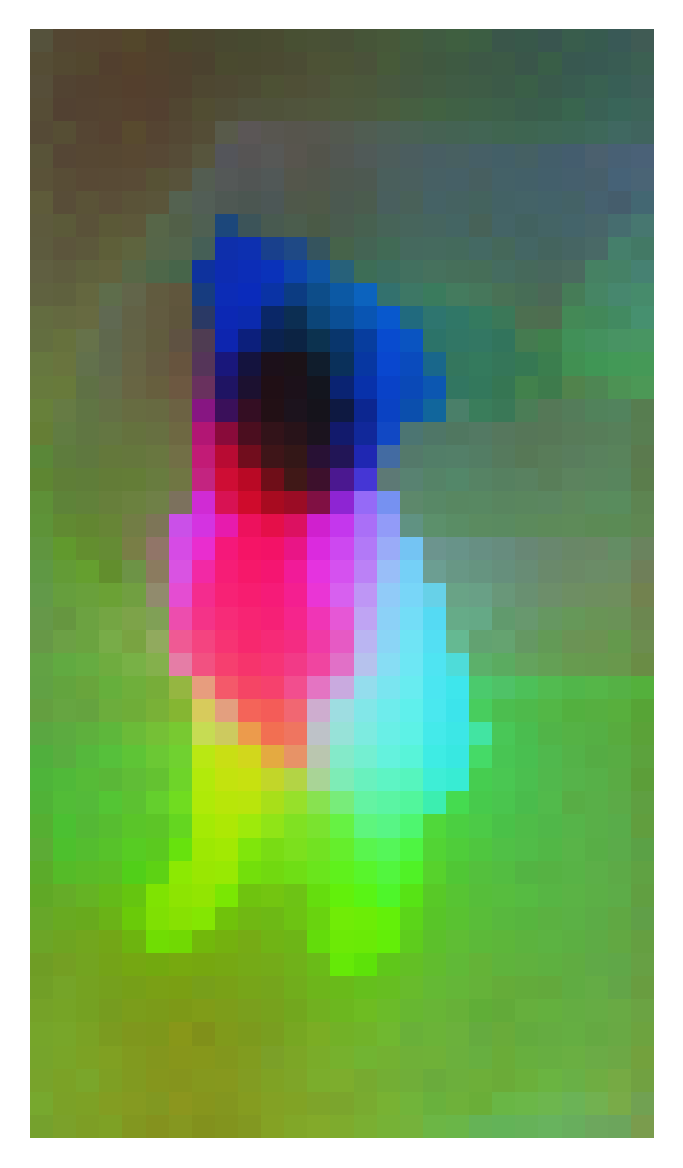

In [27]:
# apply the PCA, and then reshape
projected_image = torch.from_numpy(pca.transform(x.numpy())).view(h_patches, w_patches, 3)

# multiply by 2.0 and pass through a sigmoid to get vibrant colors 
projected_image = torch.nn.functional.sigmoid(projected_image.mul(2.0)).permute(2, 0, 1)

# mask the background using the fg_score_mf
projected_image  #*= (fg_score_mf.unsqueeze(0) > 0.5)

# enjoy
plt.figure(dpi=300)
plt.imshow(projected_image.permute(1, 2, 0))
plt.axis('off')
plt.show()